                                         description  \
0  اکنون همه گوشیهای آیفون رجیستر میشوند علی احمد...   
1  فروش رسمی آیفون ۱۶ ایران شروع قیمت نجومی پس گم...   
2  اولین ثبت سفارش آیفون سامانه جامع تجارت انجام ...   
3  شناسه ثبت آیفون سامانه جامع تجارت تعریف واردات...   
4  کلاف سردرگم آیفون بازار ایران ممنوعیت برداشته ...   

                           cluster_name  
0  Commercial Import & Legal Procedures  
1     iPhone Registration & Regulations  
2     iPhone Registration & Regulations  
3     iPhone Registration & Regulations  
4     iPhone Registration & Regulations  

Top 10 Keywords for Each Cluster:
Commercial Import & Legal Procedures: واردات, رجیستری, ممنوعیت, وزیر, دولت, تعرفه, واردات آیفون, رجیستر, باید, رفع
iPhone Registration & Regulations: ۱۶, آیفون ۱۶, گمرک, گوشیهای, رویه, اعلام, تجاری, قیمت, واردات, مسافری


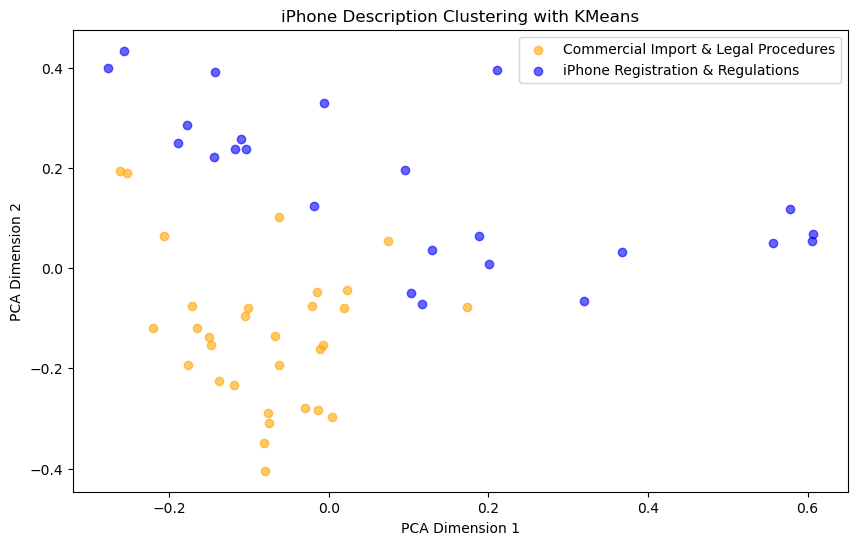

In [1]:
#### import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import re


stopwords = set(["در", "و", "به", "از", "می", "های", "که", "را", "با", "ی", "اپل", "است", "این", "گوشی", "برای", 
                  "thezoomit", "ها", "شود", "پرو", "کند", "خواهد", "شده", "کرد", "شد", "مدل", "سال", "زومیت", 
                  "جدید", "بود", "آن", "تا", "ای", "خود", "استفاده", "بخوانید", "تر", "دوربین", "دارد", "تراشه",
                  "ios", "کرده", "هوش", "دهد", "درصد", "zoomittv", "اما"])

file_path = "cleaned_iphone.csv"
df = pd.read_csv(file_path)

df = df.dropna().reset_index(drop=True)


filtered_df = df[df['description'].str.contains('آیفون', na=False)]


def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = text.split()
    words = [word for word in words if word not in stopwords]  # Remove stopwords
    return ' '.join(words)

filtered_df['description'] = filtered_df['description'].apply(preprocess_text)

descriptions = filtered_df['description'].tolist()

vectorizer = TfidfVectorizer(ngram_range=(1, 3), max_df=0.8, min_df=2)
X = vectorizer.fit_transform(descriptions)

best_score = -1
best_k = 2

for k in range(2, 3):  # Fixed to 2 clusters
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    if score > best_score:
        best_score = score
        best_k = k

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
filtered_df['cluster'] = kmeans.fit_predict(X)

terms = vectorizer.get_feature_names_out()
cluster_keywords = {i: [] for i in range(best_k)}
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(best_k):
    cluster_keywords[i] = [terms[ind] for ind in order_centroids[i, :10]] 

cluster_names = {
    0: "Commercial Import & Legal Procedures",
    1: "iPhone Registration & Regulations"
}

filtered_df['cluster_name'] = filtered_df['cluster'].map(lambda x: cluster_names.get(x, f"Cluster {x}"))

print(filtered_df[['description', 'cluster_name']].head())

print("\nTop 10 Keywords for Each Cluster:")
for cluster, keywords in cluster_keywords.items():
    print(f"{cluster_names.get(cluster, f'Cluster {cluster}')}: {', '.join(keywords)}")

X_reduced = PCA(n_components=2).fit_transform(X.toarray())
filtered_df['x'] = X_reduced[:, 0]
filtered_df['y'] = X_reduced[:, 1]

plt.figure(figsize=(10, 6))
colors = ['orange', 'blue']

for cluster in set(filtered_df['cluster']):
    cluster_points = filtered_df[filtered_df['cluster'] == cluster]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=cluster_names.get(cluster, f"Cluster {cluster}"), alpha=0.6, color=colors[cluster % len(colors)])

plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")
plt.title("iPhone Description Clustering with KMeans")
plt.legend()
plt.show()
